<a href="https://colab.research.google.com/github/ianpeterkin/DataScienceWork/blob/master/A_Pythonic_DCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from IPython.display import Image
from IPython.display import Latex
from itertools import product
import plotly
import plotly.express as px

# A Pythonic Approach to the DCF
By Ian Peterkin

# Introduction
The cornerstone of corporate finance is valuation. From investment bankers to high frequency traders, everyone in the financial industry will at some point find themselves in a position where they need to value an asset, whether that be a portfolio of properties or a large public company.

Though the financial industry has historically been an early adopeter of new technologies, the world of valuation has remained largely untouched since the advent of Microsoft Excel in the nineties. Generally an analyst will use a combination of Excel and a Bloomberg Terminal (or some other financial data provider, i.e. CapIQ, etc.), coupled with the advice of management and senior bankers to put together a limited view of a company. While this is the industry standard, this method often falls flat in regards to painting a picture of the firm that goes beyond just the raw numbers.

This article sets out to take a novel approach at visual valuation through the lens of the Jupyter notebook, an open source python programming platform. While initial valuation should still be done through Excel, wrapping everything up in a Python notebook is a great way to convey the meaning and thought behind your analysis (and also a much easier, condensed way to view a final valuation). In my experience, clients, especially those who may not be as knowledgeable about valuation, are thrilled to have a valuation that reads like a newspaper article so that they don't get lost in the abyss of a complicated excel sheet. 

Through the use of python, the savvy programmer can create valuation overviews that are not just accurate, but visual and dynamic as well.

While this article will provide an introductory overview of applying some general pythonic methods to the task of valuation, it will NOT place emphasis on the valuation methods themselves, and instead assumes a basic knowledge of general corporate finance.

I find that the best way to teach is through example, so in this article we will work through putting together a simple discounted cash flow analysis (DCF) of a made up tech firm, TechCo, stopping along the way to provide insight into the programming behind the valuation when necessary.

#Getting Started
At its core, the DCF consists of five steps:


*   Determine Drivers
*   Project Free Cash Flows
*   Calculate the Weighted Average Cost of Capital
*   Determine a Terminal Value
*   Calculate Present Value and Perform Sensitivity Analysis

In the pythonic representation of a DCF that we will set up, we will be more concerned with the last three steps, as the first two are easily done in excel, and reinventing the wheel in regards to drivers and projecting cash flows is unescessary convolusion.

Now, a little background on our Company, TechCo:
TechCo is a SaaS Company founded 10 years ago. After exhibiting promising growth over its initial ten year stint, management has decided the time to sell has come. As our MD's cousin's roommate's boyfriend played golf once in the 80's with the CEO, our bank won the contract to run the sale. Our task as an analyst is to run a multitude of valuations, including the DCF. While we did most of the analysis in Excel, the CEO isn't very privvy to the intricaies of corporate finance, and instead wants to see an easy to interpret walkthrough of our valuation. Being the go-getter analyst you are, you decide to put together a Jupyter notebook to accompany your excel wizardry. Let's get started!


#Determining the Drivers
This step is largely subjective, and depending on the situation, may also have the most weight on your valuation. In a standard DCF analysis the concern centers around projecting out Free Cash Flows, so credible assumptions as to sales drivers and certain non-cash addbacks will weigh heavily on your end valuation. While a large list of table handling packages exist for python, its ability to display them with the formatting that the banking industry has come to love falls short, so I generally prefer to just upload the driver section of my valuations as an image for the reader to skim over (again, they presumably have access to the accompanying excel sheet, so this isn't too much of a worry). Generally, the assumptions for the model drivers come from management's input anyhow, and they remain overwhelmingly static once they have been agreed on. Let's take a look at our TechCo. example for some guidance...

TechCo makes most of its money from three segments:

1.   Subscriptions
2.   Perpetual Licences, and
3.   Other

These are pretty typical categories for a SaaS company's revenue breakdown. Luckily, python has a very simple Image() function to display snapshots of our excel sheet. Let's see how we projected revenues in our Excel analysis:



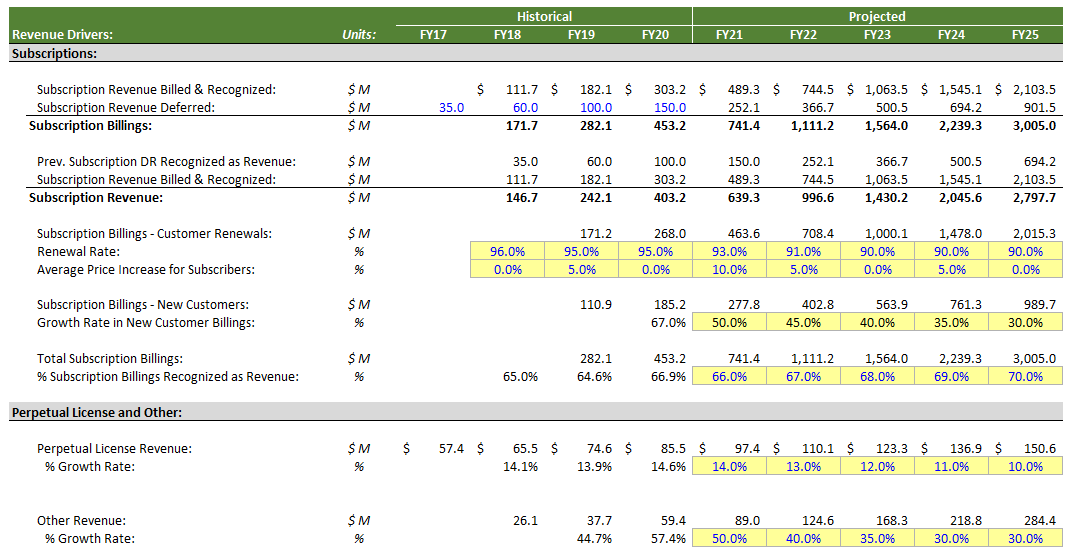

In [26]:
Image('revenue drivers.PNG', width=800, height=400)

O.K, pretty standard. As per management's guidance, we project subscription revenue in depth, factoring in the difference between billings and revenue, as well as renewals and price increases. If you'd like a more in depth explanation into why subscriptions were forecasted like this, take a look at the Financial  Modelling course from [BIWS](https://breakingintowallstreet.com/biws/homepage/), which has a litany of helpful case studies on different industries, and which heavily influenced the case in this article. Additionally, perpetual licences and other revenue were forecast as a simple growth rate. While this isn't ideal, we'll blame it on management and move on.

To get total revenues, we just add the three revenue totals together and we can start building out our bridge to FCFs.

#Project Free Cash Flows


As any good student of finance knows, the bridge to FCF looks something like this:

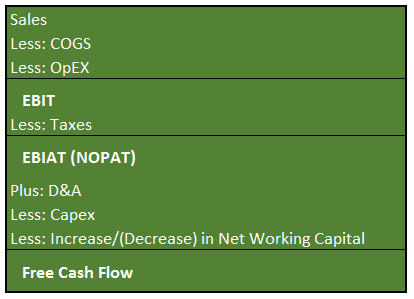

In [27]:
Image('fcf bridge.PNG')

Essentially, we are going through the income statement to calculate our taxes on the business' operations, and then adding back certain non cash expenses to find the business' core operating cash flow, which we will discount to the present to find a valuation; hence the name: Discounted Cash Flow analysis.

Clearly, we also need to do some expense projections, which management has so graciously provided. From our excel sheet:

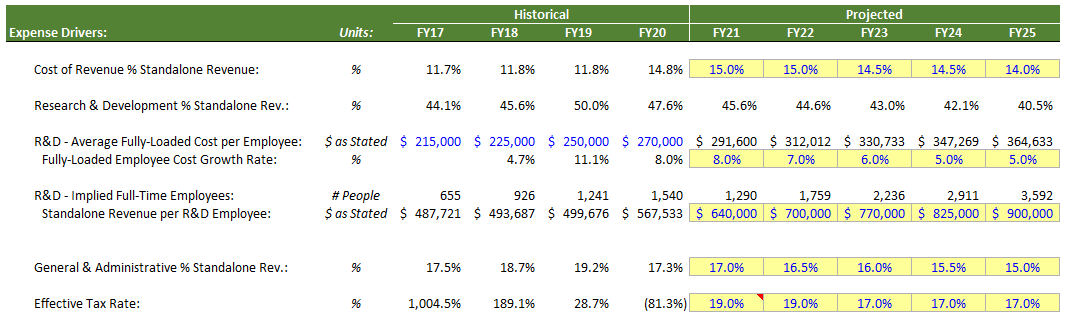

In [28]:
Image('expense drivers.PNG', width=1000, height=300)

And now, we pretty much have all we need to project out to our FCF. For the sake of saving space, I'll assume you understand how to get to EBIT from revenue. Again, from Excel:

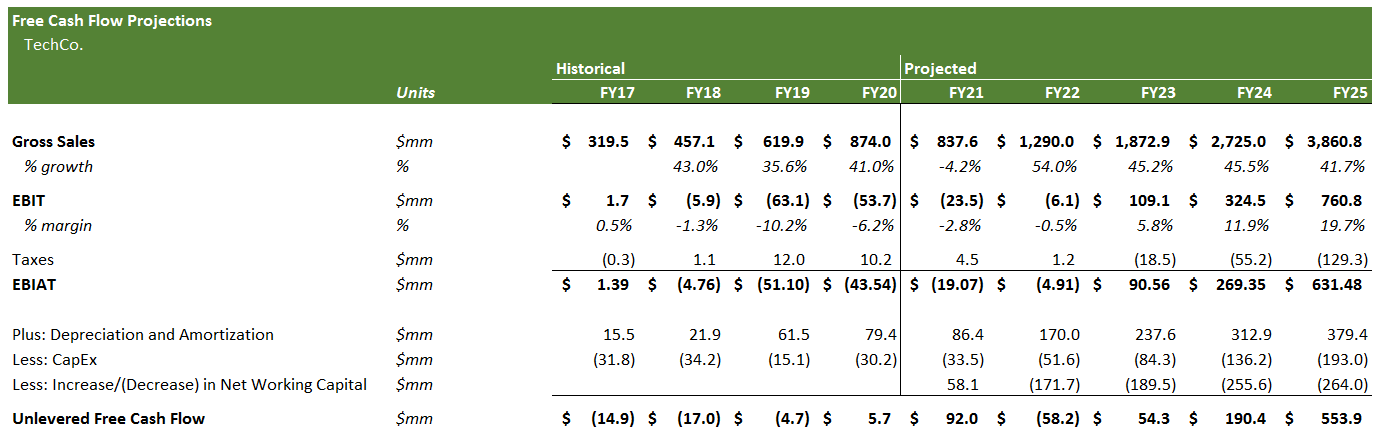

In [29]:
Image('FCF Projections.PNG',width=1000, height=300)

And there we have it, FCF prjections. A little note on taxes: I assumed a decreasing rate from 19% to 17% in perpetuity as that was management's guidance going forward. Clearly, the company generated some tax NOLs for the period; we will avoid their effects for this simple demonstration.

Now that we have our projections, we can really start using the power of the Jupyter notebook. On to step 3!

#Calculate Weighted Average Cost of Capital (WACC)

Ah yes, the WACC. A seemingly simple idea that has perplexed analysts for years. Here's the formula as a refresher:

\begin{aligned}
	WACC =
	(r_{d}\times(1+t)\times\frac{D}{D+E})
	+
	(r_{e}\times\frac{E}{D+E})
\end{aligned}

Clearly, we need some way to figure out the Company's ideal capital structure in the absence of guidance from management. 

Generally this is the most time consuming part of the DCF process, involving spreading comps and trying to come to a proper beta calculation. In the interest of saving time, however, our pythonic analysis will use some simple data science to come up with an estimate for WACC and the optimal capital structure using some starting data that we grab from bloomberg. This process serves as a sanity check on your Excel-calculated WACC, and also provides a fun exercise in applied data science.

As a starting point, Bloomberg is giving me a WACC of around 8.6% for late stage mid cap tech companies. Accounting for a size premium, let's just say our WACC will probably be around a range of 6% to 10%, give or take. Now let's run some code:

In [0]:
#Let's create a table of values representing different mixes of debt and equity.
#Remeber, the shares of debt and equity must add to one (assuming no semi-complex instruments, such as preferred)
#As the share of equity is essentially just (1-share of debt), we only need to create a range for the share of debt
#I'm seeing a pretty low average debt share on Bloomberg, which makes sense for tech companies, which generally grow through multiple rounds of equity infusions
#Because of this, let's use a range of .1 to .5
#For this, we will employ the pandas package to make a series of 25 evenly spaced values in the range:
debt_share = pd.Series(np.linspace(0.1,.5,25))

Now we have a series with a mix of different possible debt and equity shares.
These mixes will be useful when we start solving for the minimum wacc.
Now we need to assume some different costs of equity and debt. We'll use Bloomberg as a starting point.

When I check Cost of equity and Debt for similar companies, I get ranges of +/- 8% for equity and +/- 3% for debt, with quite a high variance.
This high varaince only reinforces the need for such large ranges.
Let's make some series reflecting these ranges.

In [0]:
d_cost = pd.Series(np.linspace(.02,.06,5))
e_cost = pd.Series(np.linspace(.06,.10,5))

Yes, we can argue all day on what ranges are acceptable for cost of debt, cost of equity, etc., and indeed bankers often DO argue all day over these things. We are not concerned with that! Remeber, we (presumably) did all of this analysis in Excel already, and came up with our proper ranges. We are using this process as a sanity check of our numbers!

Now, for each of the debt/equity share combinations, we want to see how each cost of debt and equity combination will affect the WACC. This gives us a lot of combinations. Luckily the Pandas package is very powerful in regards to linear algebra, and we can easily make a dataframe representing all of the combinations:

In [18]:
combos = pd.DataFrame(list(product(d_cost, e_cost, debt_share)), columns=['cod', 'coe', 'debtshare'])
print(combos)

      cod   coe  debtshare
0    0.02  0.06   0.100000
1    0.02  0.06   0.116667
2    0.02  0.06   0.133333
3    0.02  0.06   0.150000
4    0.02  0.06   0.166667
..    ...   ...        ...
620  0.06  0.10   0.433333
621  0.06  0.10   0.450000
622  0.06  0.10   0.466667
623  0.06  0.10   0.483333
624  0.06  0.10   0.500000

[625 rows x 3 columns]


Aaaaaaaaaand we get 625 possible combinations. If we had to do this by hand, it would be a lot of math. However, we're using pandas, and can simply add another column using a function that solves for each WACC:

In [19]:
#Set our effective tax rate, as per management's guidance
tax_rate = .17

#And calculate using lambda syntax
combos['WACC'] = combos.apply(lambda row: (row.cod*(1+tax_rate)*(row.debtshare))+(row.coe*(1-row.debtshare)), axis = 1) 

#now lets get the WACCs in ascending order
combos.sort_values(by = 'WACC')

,cod,coe,debtshare,WACC
24,0.02,0.06,0.500000,0.041700
23,0.02,0.06,0.483333,0.042310
22,0.02,0.06,0.466667,0.042920
21,0.02,0.06,0.450000,0.043530
20,0.02,0.06,0.433333,0.044140
...,...,...,...,...
603,0.06,0.10,0.150000,0.095530
475,0.05,0.10,0.100000,0.095850
602,0.06,0.10,0.133333,0.096027
601,0.06,0.10,0.116667,0.096523


Now, let's limit our sample space to the generally acceptable range of COE and COD values:

In [20]:
limited_combos = combos[(combos['WACC'] > .06) & (combos['WACC'] < .1)].sort_values(by = 'WACC')
limited_combos

,cod,coe,debtshare,WACC
96,0.02,0.09,0.450000,0.060030
161,0.03,0.07,0.283333,0.060112
65,0.02,0.08,0.350000,0.060190
294,0.04,0.07,0.416667,0.060333
195,0.03,0.08,0.433333,0.060543
...,...,...,...,...
603,0.06,0.10,0.150000,0.095530
475,0.05,0.10,0.100000,0.095850
602,0.06,0.10,0.133333,0.096027
601,0.06,0.10,0.116667,0.096523


And now we can see all of the parameters that go into different WACCs! So, if management wants guidance on how to achieve a certain WACC, you can offer some combinations of variable that will provide that WACC, and work towards achieving them in your financial models, whether that be through targeting certain interest rates or adjusting capital structure through some method like a recap. Essentially, we can say to management "Here is a list of every possible combination of the factors that go into acieving your optimal lowest (reasonable) WACC."

For a deeper look, let's visualize this using a tool called plotly (if you're having trouble seeing the plot, you should download the Jupyter notebook and run it on your local device):

In [32]:
fig = px.scatter_3d(limited_combos, x='cod', y='coe', z='WACC',
              color='debtshare', size='debtshare', size_max=18, opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

So what can we take away from this plot? Well, for one, as the debt share decreases, the WACC generally increases. We also see a gradual descent along the gradient to a minimum. This occurs where the costs of debt and equity are both minimized, which makes sesnse (After all, the WACC is just a weighted sum of these two values). None of this should be too surprising, but it's handy nonetheless.

Now we can determine the Company's optimal capital structure by simply finding the minimum WACC and choosing accordingly.

When I went through and spread the comps in Excel, I ended up only a few bps off of the calculated WACC, with a pretty close capital structure mix. Not too shabby for some simple (albeit educated) estimates!

Now on to step 4!

#Determine a Terminal Value
So now we're approaching the goal of our exercise, finding a valuation. We have our cash flow projections and we have our discount rate, so now we just need a terminal value. The two most common methods of going about this are the perpetuity and exit multiple methods. Since this is a pretty simple DCF, assume and end-of-year convention. Let's start with the perpetuity method.

The general idea behind the perpetuity method is that you value your terminal year cash flows as you would a perpetuity. Again, as a refresher, here's the formula:
\begin{aligned}
	Terminal\:Value_{pgm} =
	\frac{FCF_n\times(1+g)}{r-g}
\end{aligned}
Where FCF is your terminal year cash flow, g is your perpetuity growth rate, and r is your WACC. The only variable we are missing here seems to be the growth rate, but it's pretty easy to estimate (usually a few bps over the GDP growth rate). Let's use a few more lines of code to calculate the Terminal Value for our range of WACCs:

In [22]:
#Let's use our cash flow in year five as the terminal year (in millions)
terminal_cash_flow = 553.8710782

#Now define the perpetuity growth rate. The US government is projecting 3% growth, I tend to be more conservative though
#especially in low rate environments such as the current one
g = .025

#And calculate using lambda syntax
combos['TV_pgm'] = combos.apply(lambda row: ((terminal_cash_flow * (1+g))/(row.WACC-g)), axis = 1) 

#now lets get the terminal values in ascending order just for the consistency and limit to realistic WACC assumptions
combos.sort_values(by = 'TV_pgm')
combos = combos[(combos['WACC'] > .07)]
combos

,cod,coe,debtshare,WACC,TV_pgm
50,0.02,0.08,0.100000,0.074340,11506.239464
51,0.02,0.08,0.116667,0.073397,11730.515638
52,0.02,0.08,0.133333,0.072453,11963.708664
53,0.02,0.08,0.150000,0.071510,12206.361108
54,0.02,0.08,0.166667,0.070567,12459.060464
...,...,...,...,...,...
620,0.06,0.10,0.433333,0.087087,9143.957723
621,0.06,0.10,0.450000,0.086590,9217.695326
622,0.06,0.10,0.466667,0.086093,9292.631850
623,0.06,0.10,0.483333,0.085597,9368.796774


Now let's move on to the Exit Multiple Method. The general idea here is that there must be some multiple of your terminal cash flow (or some other metric; EBITDA is the industry standard)that produces a viable estimate of the terminal value. Here's the formula:

\begin{aligned}
	Terminal\:Value_{emm} =
	FCF_n\times Exit\:Multiple
\end{aligned}

Let's do some coding to come up with a range of terminal values based on a range of exit multiples. I find an industry average around 18x, so lets sensitize around that:

In [23]:
#Define a range of exit multiples (We will use the industry standard multiple for tech co's that I grabbed from CapIQ as a starting point)
emm = pd.Series(np.linspace(16,20,10))

#And calculate using TV using this method
tv_emm = emm*terminal_cash_flow
tv_emm_df = pd.DataFrame({'Exit Multiple':emm,
    'Terminal Value':tv_emm.values})
tv_emm_df

,Exit Multiple,Terminal Value
0,16.000000,8861.937251
1,16.444444,9108.102175
2,16.888889,9354.267098
3,17.333333,9600.432022
4,17.777778,9846.596946
5,18.222222,10092.761869
6,18.666667,10338.926793
7,19.111111,10585.091717
8,19.555556,10831.256640
9,20.000000,11077.421564


And would you look at that! Our exit multiple method produces terminal values that are pretty consistent with our perpetuity growth method around the realistic WACC assumptions. Let's do a little check just to make sure:

In [24]:
print("Exit multiple average: ",np.mean(tv_emm_df['Terminal Value']))
print("Perpetuity Average:    ",np.mean(combos['TV_pgm']))

Exit multiple average:  9969.679407599999
Perpetuity Average:     10491.971250682967


Again, not bad for some quick and dirty estimates. Now, on to step 5.

#Calculate Present Value
And now for the easiest part. Using the end year convention and exit multiple terminal value, our formula is as follows:
\begin{aligned}
	Enterprise\:Value =
	\sum_{i=1}^{n}\frac{FCF_n}{(1+WACC)^n}+
  \frac{Terminal\:Value\times Exit\:Multiple}{(1+WACC)^n}
\end{aligned}
Where n is the year of the cash flow, starting where n=1 represents the nearest year's cash flow and f represents the final year in which you recieve your terminal value. We can easily calculate present value of a stream of cash flows in python using the following function:

In [25]:

#Let's make a list containing our cash flows (including terminal year x exit multiple)
cash_flows = [91.9546, -58.2187, 54.2964, 190.3648, 9969.67]

#Now a list of the corresponding discount factors for each year
avg_wacc = np.mean(combos['WACC'])
drates = [1/((1+avg_wacc)**i)for i in range(1,6)]

#And now a formula to calculate
def present_value(cash_flows, drates):
  return sum([cash_flow*drate for cash_flow,drate in zip(cash_flows,drates)])

print("The enterprise value of this company, according to the EMM method, in millions, is:" ,
      present_value(cash_flows,drates))





The enterprise value of this company, according to the EMM method, in millions, is: 7003.396608272314


And there we have it. At our discount rate of 8%, this is a 7 billion dollar company, exactly what we get if we evaluate the NPV function in excel on our range of cash flows! If we wanted, we could do the same thing with our perpetuity method numbers, and we'd come up with a relatively similar number. Give it a shot!

#Conclusion
So there we go, our pythonic valuation has come to an end. Hopefully at this point the advantages of using python to accompany valuations are strikingly evident. We saw how employing data science methods can help narrow down the optimal capital structure for a company, we saw the ways in which sensitivity analysis can be proxied in a Jupyter notebook, and we explored how basic 3D graphing can serve as a powerful tool for observing the mathematical relationships that underly some of the formulas central to finance. Perhaps most importantly, we saw how using python to re-evaluate your valuations can result in a much needed sanity check, thus improving the valuation's credibility. If you have any quetions or want to discuss, feel free to start a conversation with me on LinkedIn.